# Terra 0.8 - Circuit Updates

In this tutorial, we'll discuss three advanced components of the Terra circuit building API, added in the Terra 0.8 release. 

Made with the goals of facilitating circuit construction, reuse through composition and parameterization, reducing boilerplate.

1. Optional register declarations
2. CompositeGate replacement
3. Parameterized Circuit

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

## 1. Optional register declarations

- registers useful in large circuits, but can add unneeded overhead for small circuits and tests
- Added in Terra 0.8, syntax to create and build circuits without explicit register declaration

### Registerless QuantumCircuit declaration

Standard Terra circuit declaration (still valid):

In [2]:
qr = QuantumRegister(3, name='q')
cr = ClassicalRegister(2, name='c')
qc = QuantumCircuit(qr, cr)

- for cases when only single registers, frequently the case for small circuits, quick demos or testing, could be more concise.
- Alternate argument form for `QuantumCircuit` constructor, accepts one or two integers, the number of qubits (required) and the number of classical bits or clbits (optional).

In [3]:
qc = QuantumCircuit(3, 2)

- Equivalent to above, except for fewer lines of code, and lack of user-provided handles to registers
- Registers are automatically generated based on qubit/clbit count, and can be accessed through the circuit as needed.

In [4]:
print(qc.qregs)
print(qc.cregs)

[QuantumRegister(3, 'q')]
[ClassicalRegister(2, 'c')]


### Qubit/clbit index based addressing

- To accelerate the process of building simple circuits, can address qubits and clbits directly by index.
- Works with both old (register-ful) and new (register-less) style circuit declaration.

In [6]:
bell = QuantumCircuit(2,2)
bell.h(0)
bell.cx(0, 1)
bell.measure([0,1], [0,1])

print(bell.qasm().replace('\n', " "))
bell.draw()

OPENQASM 2.0; include "qelib1.inc"; qreg q[2]; creg c[2]; h q[0]; cx q[0],q[1]; measure q[0] -> c[0]; measure q[1] -> c[1]; 


In [7]:
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(2, 'c')
bell = QuantumCircuit(qr, cr)

bell.h(qr[0])
bell.cx(qr[0], qr[1])
bell.measure(qr, cr)

print(bell.qasm().replace('\n', " "))
bell.draw()

OPENQASM 2.0; include "qelib1.inc"; qreg q[2]; creg c[2]; h q[0]; cx q[0],q[1]; measure q[0] -> c[0]; measure q[1] -> c[1]; 


- qubit vs clbit inferred from argument type (e.g. cx is (qubit, qubit) , measure is (qubit, clbit))
- follow same slicing/broadcasting conventions as used for registers
- can switch between two forms as convenient

Index ordering is set by order in which register was added to circuit, and can be verified by inspecting the circuits `qubits` and `clbits` properties

In [8]:
# Should probably be properties
print('Qubit ordering:', bell.qubits())
print('Classical bit ordering:', bell.clbits())


Qubit ordering: [(QuantumRegister(2, 'q'), 0), (QuantumRegister(2, 'q'), 1)]
Classical bit ordering: [(ClassicalRegister(2, 'c'), 0), (ClassicalRegister(2, 'c'), 1)]


## `QuantumCircuit`s and `CompositeGate`s

- Prior to 0.8, Terra used on `CompositeGate` for construction of multi-leveled circuits.
- But high level composition was difficult and ability to effectively re-use circuits was limited.
- In 0.8, `CompositeGate` is deprecated, and replaced by a more flexible form of circuit composition

### Opaque gates

Added ability to define opaque gates

In [8]:
from qiskit.circuit import Gate

my_gate = Gate(name='my_gate', num_qubits=2, params=[])
print(my_gate.qasm())

my_gate


`qc.append(instruction, qargs, cargs)` method

In [9]:
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.append(my_gate, [qr[0], qr[1]])
circ.append(my_gate, [1, 2]) # TODO Should also support circ.append(my_gate, [0, 1])?
print(circ.qasm().replace('\n', ' '))
circ.draw()

OPENQASM 2.0; include "qelib1.inc"; qreg q[3]; my_gate q[0],q[1]; my_gate q[1],q[2]; 


### Custom Composite Gates

- `qc.to_instruction` allows building circuits as components to be reused
- converts circuit to instruction (removes registers, preserves qubit/clbit indexing order)

In [10]:
# build a sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.iden(sub_q[1])
sub_circ.u3(1, 2, -2, sub_q[0]) # TODO Sub_circ's u3 params are promoted to be params of sub_circ

# convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()
q = QuantumRegister(3,'q')
circ = QuantumCircuit(q)
circ.append(sub_inst, [q[1], q[2]])
print(circ.qasm().replace('\n', ' '))
circ.draw()


OPENQASM 2.0; include "qelib1.inc"; qreg q[3]; sub_circ(1,1,2,-2) q[1],q[2]; 


- not immediatley decomposed
- allows circuit design/programming at higher/increasing levels of abstraction

Can be convenient to work at higher levels of abstraction, but for inspection, or before compilation and execution... `qc.decompose` 

In [13]:
dcirc = circ.decompose() # Does not modify original circuit
print(dcirc.qasm().replace('\n', ' '))
dcirc.draw()

OPENQASM 2.0; include "qelib1.inc"; qreg q[3]; h q[1]; crz(1) q[1],q[2]; barrier q[1],q[2]; u3(1,2,-2) q[1]; id q[2]; 


TODO: Replace example: QFT -> Shor?

## Parameterized circuits

Variational algorithms, circuit libraries

- Parameterized Circuit
- Allow to bind parameters to variables

Parameters can be used anywhere numeric constants can be used, e.g. for gate assignments

In [15]:
from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5
qc = QuantumCircuit(5, 1)
qr = qc.qregs[0]
qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)
qc.barrier()
qc.rz(theta, range(5))
qc.barrier()
for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.measure(0, 0)
print(qc.qasm().replace('\n', '\n'))
qc.draw()

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[1];
h q[0];
cx q[0],q[1];
cx q[1],q[2];
cx q[2],q[3];
cx q[3],q[4];
barrier q[0],q[1],q[2],q[3],q[4];
rz(θ) q[0];
rz(θ) q[1];
rz(θ) q[2];
rz(θ) q[3];
rz(θ) q[4];
barrier q[0],q[1],q[2],q[3],q[4];
cx q[3],q[4];
cx q[2],q[3];
cx q[1],q[2];
cx q[0],q[1];
h q[0];
measure q[0] -> c[0];



In [16]:
print(qc.parameters)

{Parameter(θ)}


Presently, must declare/bind/assign/fix all variables before sending a circuit of to a device

- `bind_parameters` returns new copy of circuit w/ parmeter replaced
- can partially asign, in which case you get back a new parameterized circuit with n-1 parameters (or n less the number of parameters assigned)

In [29]:
import numpy as np

theta_range = np.linspace(0, 2 * np.pi, 128)
circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]

print(circuits[-1].qasm().replace('\n', '\n'))
print(circuits[-1].draw(line_length=120))
print(circuits[-1].parameters)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[1];
h q[0];
cx q[0],q[1];
cx q[1],q[2];
cx q[2],q[3];
cx q[3],q[4];
barrier q[0],q[1],q[2],q[3],q[4];
rz(6.283185307179586) q[0];
rz(6.283185307179586) q[1];
rz(6.283185307179586) q[2];
rz(6.283185307179586) q[3];
rz(6.283185307179586) q[4];
barrier q[0],q[1],q[2],q[3],q[4];
cx q[3],q[4];
cx q[2],q[3];
cx q[1],q[2];
cx q[0],q[1];
h q[0];
measure q[0] -> c[0];

        ┌───┐                     ░ ┌────────────┐ ░                     ┌───┐┌─┐
q_0: |0>┤ H ├──■──────────────────░─┤ Rz(6.2832) ├─░──────────────────■──┤ H ├┤M├
        └───┘┌─┴─┐                ░ ├────────────┤ ░                ┌─┴─┐└───┘└╥┘
q_1: |0>─────┤ X ├──■─────────────░─┤ Rz(6.2832) ├─░─────────────■──┤ X ├──────╫─
             └───┘┌─┴─┐           ░ ├────────────┤ ░           ┌─┴─┐└───┘      ║ 
q_2: |0>──────────┤ X ├──■────────░─┤ Rz(6.2832) ├─░────────■──┤ X ├───────────╫─
                  └───┘┌─┴─┐      ░ ├────────────┤ ░      ┌─┴─┐└───┘           ║ 
q_3: |0>─

In [23]:
from qiskit import BasicAer, execute

## Following are equivalent:
#job = execute(circuits, backend=BasicAer.get_backend('qasm_simulator'))
job = execute(qc,
              backend=BasicAer.get_backend('qasm_simulator'),
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])

counts = [job.result().get_counts(i) for i in range(len(job.result().results))]


- For example experiment, applying global $R_z(\theta)$ rotation on 5-qubit entangled state
- Expect to see oscillation in qubit-0 at $5\theta$

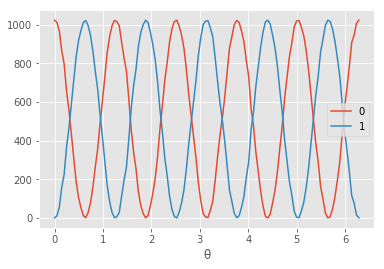

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
plt.style.use('ggplot')

fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), label='1') 

ax.set_xlabel('θ')
ax.legend()
plt.show()

# Composition

when composing circuits, parameters of resulting circuit is union of parameters of joined circuits

- Name collision (TODO), if I try to add another parameter, also named θ:
 - If it's a different Parameter instance, an error will be raised
 - If it's the same Parameter instance, the new instruction will add to the circuit, parameterized by the circuits original θ


# compilation cost
- If I wanted to run for a device, would have to normally compile all circuits
- But now, can compile parameterized circuit once (shorter), assign, and then recompile
- In some cases (depending on what is causing transapile to be slow) be faster

In [30]:
# old way
import time
from itertools import combinations
from qiskit.compiler import transpile
from qiskit.test.mock import FakeTokyo

qc = QuantumCircuit(20)

for k in range(32):
    for i,j in combinations(range(20), 2):
        qc.cx(i,j)
    qc.rz(theta, range(20))
    for i,j in combinations(range(20), 2):
        qc.cx(i,j)

qcs = [qc.bind_parameters({theta: n}) for n in np.linspace(0, 2*np.pi, 512)]
start = time.time()
compiled_circuits = transpile(qcs, {'backend': FakeTokyo()}) # TODO Should be a transpileConfig?
end = time.time()
print(end-start)

927.7456729412079


In [ ]:
start = time.time()
qc1 = transpile(qc, {'backend': FakeTokyo()})
compiled_circuits = transpile([qc1.bind_parameters({theta: n}) for n in np.linspace(0, 2*np.pi, 512)], {'backend': FakeTokyo()})
end = time.time()
print(end-start)

# Support for parameterized circuits in either assemble circuits and execute

- execute should be smart enough to compile/assign/compile correctly for parameterized circuits
- if you assemble, you have to manage transpile/assign/transpile/assemble 

In [ ]:
job = execute(qc1, backend=BasicAer.get_backend('qasm_simulator'),
              parameter_binds= [{ theta: 0}, {theta: 1}, { theta: 2}, ...])

### Shorthand symbols (TODO 0.9?)

- In some casese, (if not intending to reuse symbols across subcircuits?), it should be sufficient to provide a string which will be wrapped up as a terra Parameter
- TODO Needs further design, understand implications with name collision

In [ ]:
e.g. qc = QuantumCircuit(3)
qc.u3('theta', 'phi', 'λ', 0)
qc.u1('theta', 0)  # TODO Requires some thinking? When can we safely assume this to be the same as the theta above?

qc.variables

# bind_parameters, execute and RunConfig could accept strings additionally

In [ ]:
# range constructor (TODO 0.9?)
# ryrz, shorthand for creating/binding bundles of parameters

## Bringing it all together: QPE Demo